In [1]:
# importing required libraries
import matplotlib
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import sys
from IPython.display import display
from IPython.display import Image
import warnings
import matplotlib.pyplot as plt
import datetime
import pycountry_convert as pc
import pycountry
import folium
import joblib
from folium.plugins import MarkerCluster
from geopy.geocoders import Nominatim

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer

from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.tree import export_graphviz
import pydot
import seaborn as sns

import time

# library options
%matplotlib inline
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

## Read in the Train and Test data

In [2]:
X_train = np.array(pd.read_parquet('../data/final/X_train.parquet')).astype('float')
X_test = np.array(pd.read_parquet('../data/final/X_test.parquet')).astype('float')

y_test_class = np.array(pd.read_parquet('../data/final/y_test.parquet')['sum_payments_package_key_ltv_class'])
y_train_class = np.array(pd.read_parquet('../data/final/y_train.parquet')['sum_payments_package_key_ltv_class'])                        
n_class = 3

### Extra without transactional data

In [3]:
X1 = pd.read_parquet('../data/final/X_train.parquet')
X2 = pd.read_parquet('../data/final/X_test.parquet')
y1 = np.array(pd.read_parquet('../data/final/y_train.parquet')['sum_payments_package_key_ltv_class'])
y2 = np.array(pd.read_parquet('../data/final/y_test.parquet')['sum_payments_package_key_ltv_class'])

In [14]:
X1 = X1.drop(axis=0, columns=['sum_day_1','sum_day_2','sum_day_3','gradient','clumpiness'])
X2 = X2.drop(axis=0, columns=['sum_day_1','sum_day_2','sum_day_3','gradient','clumpiness'])
X = np.concatenate((X1, X2), axis=0).astype('float')
y = np.concatenate((y1, y2), axis=0)

In [15]:
rfc = RandomForestClassifier(n_estimators = 150, random_state = 42)
score = cross_val_score(estimator=rfc, X=X, y=y, cv=10)
print(score)
print("The mean is " + str(score.mean()) + " with a standard deviation of " + str(score.std()))

[0.84743094 0.84957779 0.84685845 0.84886217 0.85208244 0.84793187
 0.84972091 0.85430084 0.84571347 0.84412796]
The mean is 0.848660685043374 with a standard deviation of 0.0028292879173496114


In [16]:
rfc = RandomForestClassifier(n_estimators = 150, random_state = 42)
score = cross_val_score(estimator=rfc, X=X, y=y, cv=10, scoring = make_scorer(cohen_kappa_score))
print(score)
print("The mean is " + str(score.mean()) + " with a standard deviation of " + str(score.std()))

[0.76852327 0.77164884 0.76752177 0.77067071 0.77538901 0.76922688
 0.77186163 0.77866389 0.76570303 0.76326219]
The mean is 0.7702471218775105 with a standard deviation of 0.004276799318996175


## RF

### Classifier

In [4]:
rfc = RandomForestClassifier(n_estimators = 150, random_state = 42)

# Train the model on training data
rfc.fit(X_train, y_train_class)

RandomForestClassifier(n_estimators=150, random_state=42)

In [5]:
y_pred_c = rfc.predict(X_test)

In [6]:
# Model Accuracy, how often is the classifier correct?
print("Test Set Accuracy:",metrics.accuracy_score(y_test_class, y_pred_c))
print('MAE: %.3f (%.3f)' % (np.mean(y_pred_c), np.std(y_pred_c)))

Test Set Accuracy: 0.8483970230427937
MAE: 0.924 (0.744)


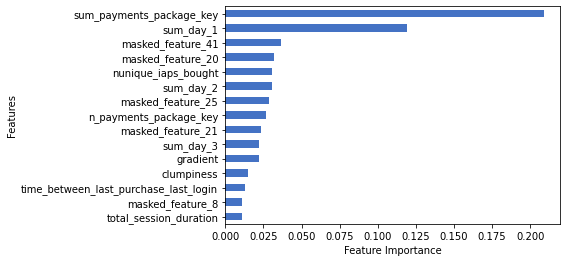

In [8]:
feat_importances = pd.Series(rfc.feature_importances_, index=X1.columns)

feat_importances.sort_values(ascending=True).nlargest(15).plot(kind='barh', color = '#4472C4')
plt.gca().invert_yaxis()
plt.ylabel('Features')
plt.xlabel('Feature Importance')

plt.show()

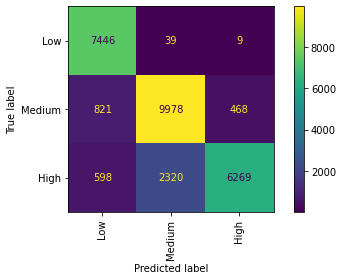

In [7]:
cm = confusion_matrix(y_test_class, y_pred_c)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low','Medium','High'])
disp.plot()
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('../pictures/RF_Class_Confusion.png')

### Tuning

In [11]:
for i in [20,40,60,80,100,120,150,200]:
    rfc = RandomForestClassifier(n_estimators = i, random_state = 42)
    rfc.fit(X_train, y_train_class)
    y_pred_c = rfc.predict(X_test)
    print("Test Set Accuracy for", i, "trees:", metrics.accuracy_score(y_test_class, y_pred_c))

Test Set Accuracy for 20 trees: 0.8433877200515243
Test Set Accuracy for 40 trees: 0.8457850293402033
Test Set Accuracy for 60 trees: 0.8462859596393302
Test Set Accuracy for 80 trees: 0.8474309431801917
Test Set Accuracy for 100 trees: 0.8477529698010591
Test Set Accuracy for 120 trees: 0.8480392156862745
Test Set Accuracy for 150 trees: 0.8483970230427937
Test Set Accuracy for 200 trees: 0.8491484184914841


#### 10 Fold Cross Validation

In [11]:
rfc = RandomForestClassifier(n_estimators = 150, random_state = 42)
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train_class, y_test_class), axis=0)

score = cross_val_score(estimator=rfc, X=inputs, y=targets, cv=10)
print(score)
print("The mean is " + str(score.mean()) + " with a standard deviation of " + str(score.std()))

[0.85115214 0.85258337 0.85022184 0.85079433 0.85601832 0.85143839
 0.85329898 0.85687706 0.84986403 0.84734846]
The mean is 0.8519596919168293 with a standard deviation of 0.0027164862661790135


In [12]:
rfc = RandomForestClassifier(n_estimators = 150, random_state = 42)
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train_class, y_test_class), axis=0)

score = cross_val_score(estimator=rfc, X=inputs, y=targets, cv=10, scoring = make_scorer(cohen_kappa_score))
print(score)
print("The mean is " + str(score.mean()) + " with a standard deviation of " + str(score.std()))

[0.77421863 0.77630011 0.77259955 0.77361322 0.78143853 0.77464292
 0.77732864 0.78268249 0.77212787 0.76817868]
The mean is 0.7753130642641712 with a standard deviation of 0.004120810460814876


# OLD
## Visualize most important features

In [86]:
feature_list = list(pd.read_parquet('../data/final/X_train.parquet').columns)

feature_imp = pd.Series(dtc.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp[:20]

sum_day_1                        0.429174
masked_feature_41                0.407577
masked_feature_20                0.163249
n_ad_reward_claims               0.000000
first_login_country_ID           0.000000
first_login_country_BR           0.000000
first_login_country_CA           0.000000
first_login_country_DE           0.000000
first_login_country_EU_Others    0.000000
first_login_country_FR           0.000000
first_login_country_GB           0.000000
first_login_country_IN           0.000000
first_login_country_AS_Others    0.000000
first_login_country_JP           0.000000
first_login_country_KR           0.000000
first_login_country_MY           0.000000
first_login_country_NA_Others    0.000000
first_login_country_NL           0.000000
first_login_country_OC_Others    0.000000
first_login_country_PH           0.000000
dtype: float64

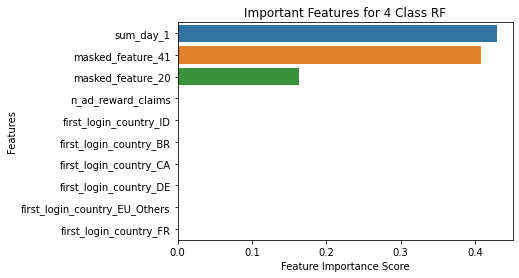

In [87]:
sns.barplot(x=feature_imp, y=feature_imp.index, order=feature_imp.iloc[:10].index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Important Features for 4 Class RF")
plt.show()

# Visualization

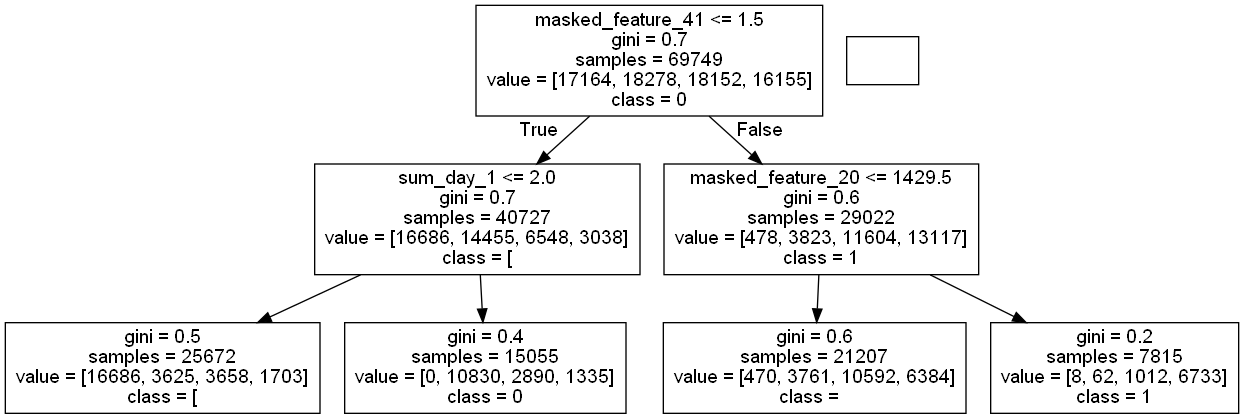

In [93]:
# Pull out one tree from the forest
tree = loaded_dtc
# Export the image to a dot file
export_graphviz(tree, out_file = 'data/tree.dot', feature_names = feature_list, class_names = str(tree.classes_), precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('data/tree.dot')
# Write graph to a png file
graph.write_png('pictures/tree.png')
Image('pictures/tree.png')

In [56]:
# Get numerical feature importances
importances = list(loaded_dtc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: sum_payments_package_key Importance: 0.63
Variable: total_session_duration Importance: 0.02
Variable: clumpiness           Importance: 0.02
Variable: n_ads_watched        Importance: 0.01
Variable: n_battlepass_lvls_finished Importance: 0.01
Variable: masked_feature_2     Importance: 0.01
Variable: masked_feature_3     Importance: 0.01
Variable: masked_feature_6     Importance: 0.01
Variable: masked_feature_8     Importance: 0.01
Variable: masked_feature_13    Importance: 0.01
Variable: masked_feature_20    Importance: 0.01
Variable: masked_feature_23    Importance: 0.01
Variable: masked_feature_25    Importance: 0.01
Variable: masked_feature_27    Importance: 0.01
Variable: masked_feature_28    Importance: 0.01
Variable: masked_feature_35    Importance: 0.01
Variable: masked_feature_37    Importance: 0.01
Variable: n_missions_completed Importance: 0.01
Variable: n_package_info_offers_viewed Importance: 0.01
Variable: n_package_tips_offers_viewed Importance: 0.01
Variable: ma

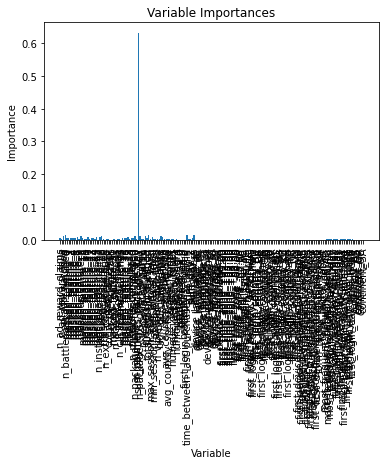

In [57]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');